In [ ]:
# 🧠 Interpretabilidad con SHAP – Paso 1


In [1]:
# 1.1 – Imports
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from joblib import load
import sys
from pathlib import Path


In [2]:
ROOT = Path.cwd().parent
sys.path.append(str(ROOT))

In [ ]:
# Importación de funciones personalizadas

In [3]:
from src.explainability import (
    crear_explainer,
    graficar_importancia_global_shap,
    graficar_explicacion_individual_shap,
    asegurar_directorio_salida
)

In [4]:
# 🔧 Asegurar que exista la carpeta donde se va a guardar los gráficos
asegurar_directorio_salida("../outputs/plots")

In [5]:
from src.preprocessing import (
    load_and_clean_data,
    split_features_target,
    split_data
)

In [6]:
# 1.3 – Cargar datos limpios
df = load_and_clean_data("../data/raw/WA_Fn-UseC_-Telco-Customer-Churn.csv")
X, y, cat_cols, num_cols = split_features_target(df)
X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y)

In [7]:
# 1.4 – Cargar preprocesador y transformar X_val
preprocessor = load("../models/preprocessor.joblib")
X_val_pre = preprocessor.transform(X_val)
X_train_pre = preprocessor.transform(X_train)

In [9]:
# 1.5 – Cargar modelo ya entrenado
xgb = load("../models/churn_xgb.joblib")  # Cambia el nombre si guardaste con otro

In [ ]:
# 2️⃣ Crear el explainer de SHAP y calcular los valores


In [10]:
# Usamos el modo para modelos de árboles (como XGBoost)
explainer = crear_explainer(xgb, X_train_pre)

In [11]:
# Calculamos los valores SHAP sobre el conjunto de validación
shap_values = explainer(X_val_pre)
print("✅ SHAP values calculados correctamente.")

✅ SHAP values calculados correctamente.


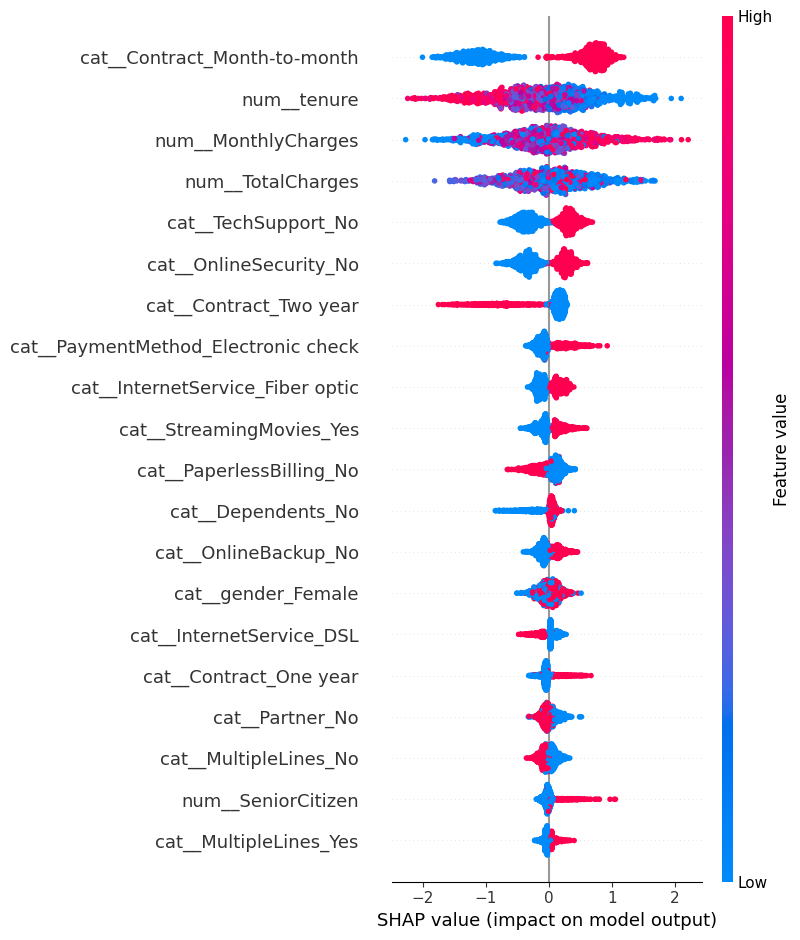

In [12]:
# 3️⃣ Interpretabilidad Global – summary_plot

graficar_importancia_global_shap(
    explainer,
    X_val_pre,
    nombres_columnas=preprocessor.get_feature_names_out(),
    nombre_archivo="../outputs/plots/shap_summary.png"
)


In [13]:
# Elegimos un índice de ejemplo
i = 0  # Podés cambiarlo por cualquier otro índice de X_val

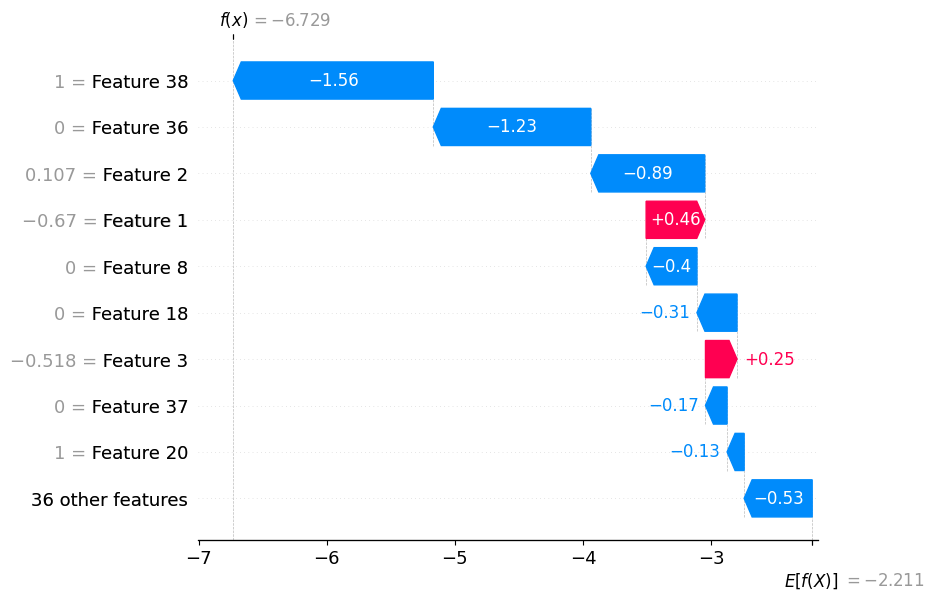

In [14]:
# Waterfall plot: cómo cada feature empuja la predicción
graficar_explicacion_individual_shap(
    explainer,
    X_val_pre,
    index=i,
    nombres_columnas=preprocessor.get_feature_names_out(),
    nombre_archivo=f"../outputs/plots/shap_waterfall_idx{i}.png"
)

In [15]:
#Elegir un ejemplo de validación (un cliente)
i = 25  # Cambiá este índice para analizar otro cliente


In [16]:
#Mostrar sus características originales
X_val.iloc[i]

gender                                 Female
SeniorCitizen                               0
Partner                                    No
Dependents                                 No
tenure                                     72
PhoneService                              Yes
MultipleLines                             Yes
InternetService                   Fiber optic
OnlineSecurity                            Yes
OnlineBackup                              Yes
DeviceProtection                          Yes
TechSupport                               Yes
StreamingTV                               Yes
StreamingMovies                           Yes
Contract                             Two year
PaperlessBilling                          Yes
PaymentMethod       Bank transfer (automatic)
MonthlyCharges                         116.45
TotalCharges                          8013.55
Name: 1746, dtype: object

In [17]:
#Mostrar la predicción del modelo
proba = xgb.predict_proba(X_val_pre[i].reshape(1, -1))[0][1]
print(f"Probabilidad de abandono: {proba:.2f}")

Probabilidad de abandono: 0.00


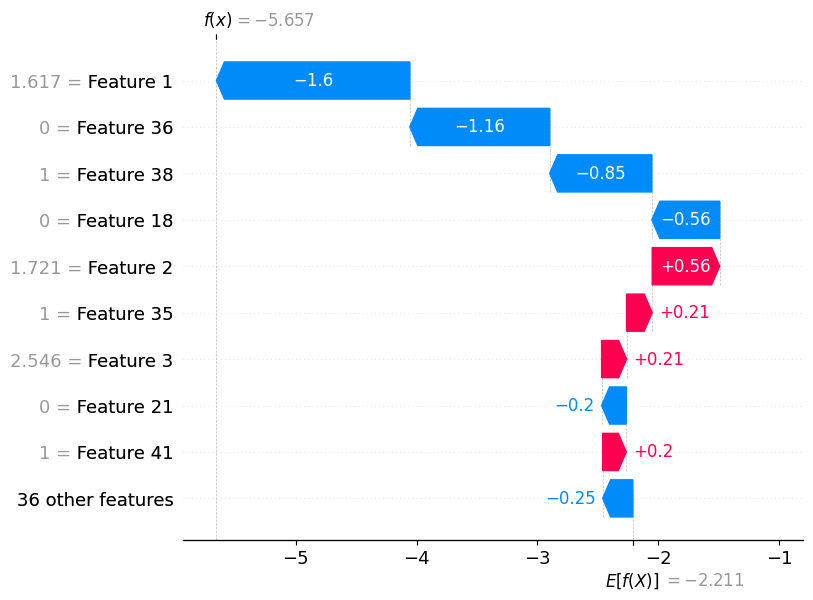

In [18]:
#Visualizar el impacto de cada feature en esa predicción
shap.plots.waterfall(shap_values[i])

In [19]:
preprocessor.get_feature_names_out()

array(['num__SeniorCitizen', 'num__tenure', 'num__MonthlyCharges',
       'num__TotalCharges', 'cat__gender_Female', 'cat__gender_Male',
       'cat__Partner_No', 'cat__Partner_Yes', 'cat__Dependents_No',
       'cat__Dependents_Yes', 'cat__PhoneService_No',
       'cat__PhoneService_Yes', 'cat__MultipleLines_No',
       'cat__MultipleLines_No phone service', 'cat__MultipleLines_Yes',
       'cat__InternetService_DSL', 'cat__InternetService_Fiber optic',
       'cat__InternetService_No', 'cat__OnlineSecurity_No',
       'cat__OnlineSecurity_No internet service',
       'cat__OnlineSecurity_Yes', 'cat__OnlineBackup_No',
       'cat__OnlineBackup_No internet service', 'cat__OnlineBackup_Yes',
       'cat__DeviceProtection_No',
       'cat__DeviceProtection_No internet service',
       'cat__DeviceProtection_Yes', 'cat__TechSupport_No',
       'cat__TechSupport_No internet service', 'cat__TechSupport_Yes',
       'cat__StreamingTV_No', 'cat__StreamingTV_No internet service',
       'cat__

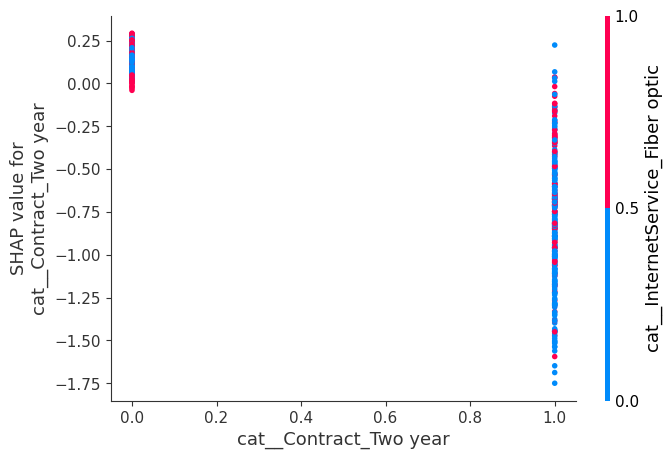

In [20]:
shap.dependence_plot(
    ind="cat__Contract_Two year",
    shap_values=shap_values.values,  # <- esta es la corrección
    features=X_val_pre,
    feature_names=preprocessor.get_feature_names_out()
)

In [21]:
import shap
import matplotlib.pyplot as plt
import os
import numpy as np

def generar_dependence_plots_top5_corregido(shap_values, X, preprocessor, save_path="../outputs/plots/"):
    """Genera dependence plots para las 5 features más importantes."""
    
    # Asegurar carpeta
    os.makedirs(save_path, exist_ok=True)
    
    # Obtener nombres de features
    feature_names = preprocessor.get_feature_names_out()
    
    # Calcular importancia global (suma de valores absolutos)
    shap_sum = np.abs(shap_values.values).mean(axis=0)
    top_indices = np.argsort(shap_sum)[-5:][::-1]
    
    print("Top 5 features más importantes:")
    for i in top_indices:
        print(f"{i}: {feature_names[i]}")
    
    # Graficar
    for i in top_indices:
        plt.figure()
        shap.dependence_plot(
            ind=i,
            shap_values=shap_values.values,  # ← importante
            features=X,
            feature_names=feature_names,
            show=False
        )
        plt.title(f"Dependence Plot – {feature_names[i]}")
        plt.tight_layout()
        plt.savefig(f"{save_path}dependence_plot_{feature_names[i].replace(' ', '_').replace('/', '_')}.png")
        plt.close()

In [22]:
generar_dependence_plots_top5_corregido(
    shap_values=shap_values,
    X=X_val_pre,
    preprocessor=preprocessor
)

Top 5 features más importantes:
36: cat__Contract_Month-to-month
1: num__tenure
2: num__MonthlyCharges
3: num__TotalCharges
27: cat__TechSupport_No
